Gradient Boost Ranking is a machine learning technique designed for ranking tasks, where the objective is to predict the relative order of items rather than their exact values. It is commonly used in scenarios such as:

Search Engines: Ranking search results.
Recommender Systems: Ranking items based on user preferences.
Ad Placement: Ranking ads based on relevance.
This technique uses pairwise or listwise ranking approaches:

Pairwise: Compares pairs of items and minimizes errors in their relative order.
Listwise: Considers the entire list of items and optimizes metrics like NDCG (Normalized Discounted Cumulative Gain).

Step 1: Setup and Import Libraries


In [1]:
# Install necessary libraries
!pip install xgboost lightgbm catboost -q

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRanker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Step 2: Create a Ranking Dataset

* Simulated using make_classification, with relevance scores derived from class probabilities.
* Grouping ensures items belong to different groups, simulating ranking problems like search results or recommendations.


In [2]:
# Simulate a ranking dataset
# For simplicity, we use a classification dataset and treat probabilities as relevance scores
X, y = make_classification(
    n_samples=1000, n_features=10, n_informative=5, n_classes=3, random_state=42
)

# Grouping for ranking (e.g., 10 items per group)
groups = np.repeat(10, len(y) // 10)  # Assume 10 items per group
group_ids = np.arange(len(groups)).repeat(groups)  # Group IDs for each sample

# Split into train and test
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    X, y, group_ids, test_size=0.3, random_state=42
)


Step 3: XGBoost Ranking
* Uses the rank:pairwise objective to optimize pairwise ranking errors.
* Outputs NDCG score to evaluate ranking quality.

In [3]:
# Prepare the data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train XGBoost Ranker
xgb_params = {
    "objective": "rank:pairwise",
    "eval_metric": "ndcg",
    "learning_rate": 0.1,
    "max_depth": 3,
    "random_state": 42,
}
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)

# Predictions and evaluation
y_pred_xgb = xgb_model.predict(dtest)
ndcg_xgb = ndcg_score([y_test], [y_pred_xgb])
print(f"XGBoost NDCG Score: {ndcg_xgb:.2f}")


XGBoost NDCG Score: 0.95


Step 4: LightGBM Ranking
* Uses lambdarank for ranking tasks, optimizing listwise ranking metrics like NDCG.
* Handles grouping information efficiently.

Step 1: Generate Correct Groups

In [11]:
# Adjust the groups to match the dataset size
# Assuming 10 items per group
group_train = [10] * (len(X_train) // 10)  # Groups of 10 items
group_test = [10] * (len(X_test) // 10)    # Groups of 10 items

# Handle leftover rows
remainder_train = len(X_train) % 10
remainder_test = len(X_test) % 10

if remainder_train > 0:
    group_train.append(remainder_train)

if remainder_test > 0:
    group_test.append(remainder_test)


Step 2: Prepare LightGBM Dataset


In [12]:
# Create LightGBM dataset
lgb_train = lgb.Dataset(X_train, label=y_train, group=group_train)
lgb_test = lgb.Dataset(X_test, label=y_test, group=group_test, reference=lgb_train)


Step 3: Train LightGBM Ranker

In [13]:
# Train LightGBM Ranker
lgb_params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.1,
    "max_depth": -1,
    "random_state": 42,
    "verbosity": -1
}

lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_test]
)

# Predictions and evaluation
y_pred_lgb = lgb_model.predict(X_test)
ndcg_lgb = ndcg_score([y_test], [y_pred_lgb])
print(f"LightGBM NDCG Score: {ndcg_lgb:.2f}")


LightGBM NDCG Score: 0.99


Step 5: CatBoost Ranking

* A dedicated ranker that uses group information for ranking tasks.
* Requires minimal preprocessing and works well out of the box.

In [15]:
# Generate group_id array for CatBoost
n_groups = len(X_train) // 10  # Number of groups (10 items per group)
group_id = np.repeat(np.arange(n_groups), 10)

# Handle remaining rows
remainder = len(X_train) % 10
if remainder > 0:
    group_id = np.append(group_id, [n_groups] * remainder)

print(f"Length of group_id: {len(group_id)}, Length of X_train: {len(X_train)}")

assert len(group_id) == len(X_train), "Mismatch between group_id and X_train length"


cat_model = CatBoostRanker(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_seed=42)

# Train the CatBoost model
cat_model.fit(X_train, y_train, group_id=group_id)

# Predictions and evaluation
y_pred_cat = cat_model.predict(X_test)
ndcg_cat = ndcg_score([y_test], [y_pred_cat])
print(f"CatBoost NDCG Score: {ndcg_cat:.2f}")


Length of group_id: 700, Length of X_train: 700
CatBoost NDCG Score: 0.99


Step 6: Visualize Results

* A popular metric for ranking, measuring the quality of the predicted ranking against the true relevance scores.
* Bar plot compares NDCG scores across models, showing their relative performance.

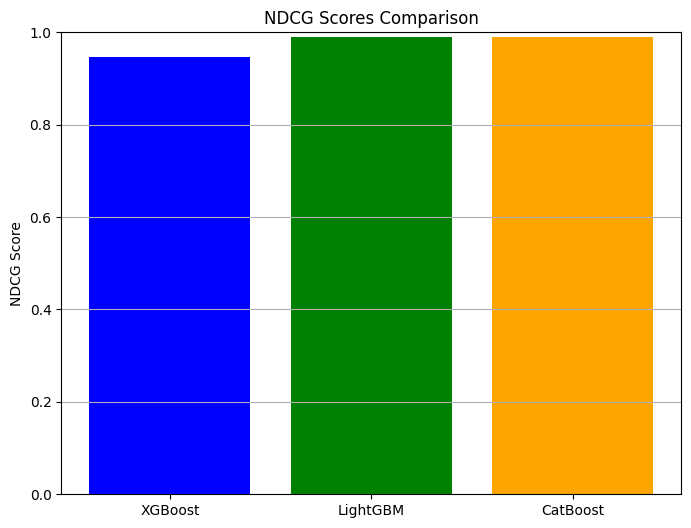

In [16]:
# Bar plot for NDCG scores
ndcg_scores = [ndcg_xgb, ndcg_lgb, ndcg_cat]
models = ["XGBoost", "LightGBM", "CatBoost"]

plt.figure(figsize=(8, 6))
plt.bar(models, ndcg_scores, color=["blue", "green", "orange"])
plt.title("NDCG Scores Comparison")
plt.ylabel("NDCG Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
